# ENEN90032 - Assignment 2

## Hypothesis Test and Statistical Significance in Time Series Data

This notebook implements Q1 (ANTSIE/ASIE anomaly analysis and significance tests) as requested. 

**Usage:** Downloaded ADS CSV files for Antarctic and Arctic monthly mean SIE are in the `data/` folder.<br>
The Requirements are the same with the ones used in assignment 1.

## What the Notebook does:
    Loads both datasets from the `data/` folder.<br>
    Computers the momthly anomalies using a 1979-2024 for reference. Seasonality is removed by the monthly climatology.<br>
    Plots ensemble- style monthly anomaly figures (years overlaid; highlights the target year).<br>
    Computes empirical probabilities:
    Chance of observing ANTSIE in Aug 2023 or smaller using all months and using August-only samples.<br>
    Same for ASIE Sep 2012.<br>
    Repeats the ANTSIE calculation using Jan 2017–Dec 2022 as an alternative reference.<br>
    Fits a linear trend to ASIE anomalies and tests slope significance using an AR(1)-corrected effective sample size (Santer-like correction).
    If slope is significant, it recomputes anomaly/probability accounting for trend.<br>
    All code is annotated and uses the allowed libraries (numpy, pandas, matplotlib, scipy.stats, math, statsmodels).<br>


In [62]:
# Constants 
# Data files
ANT_SIE_CSV = 'data/vishop_extent_antarctic_sea_ice_extent.csv'   
ARC_SIE_CSV  = 'data/vishop_extent_arctic_sea_extent.csv'   
# Reference periods
REF_START = 1979
REF_END = 2024

# Alternative reference for Q1.3
RECENT_START = 2017
RECENT_END = 2022

# Month/year of interest
AUG_2023 = (2023, 8)
SEP_2012 = (2012, 9)


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math
import statsmodels.api as sm

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (9,5)

from datetime import datetime

np.random.seed(2025)


In [64]:
def load_ads_monthly_csv(path):
    """
    Flexible loader for ADS monthly mean SIE CSVs.
    Handles two common formats:
    1. Columns: 'Year','Mon' (or 'Month'), plus a numeric extent column.
    2. A combined 'Date' or 'YYYY-MM' column, plus a numeric extent column.
    """
    # detect first row of data
    start_idx = 0
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if line.strip() and line[0].isdigit():
                start_idx = i
                break

    df = pd.read_csv(path, skiprows=start_idx)

    # Normalize col names
    cols = [c.lower() for c in df.columns]

    # Case 1: has Year and Month columns
    if any("year" in c for c in cols) and any("mon" in c or "month" in c for c in cols):
        year_col = next(c for c in df.columns if "year" in c.lower())
        month_col = next(c for c in df.columns if "mon" in c.lower() or "month" in c.lower())
        df['date'] = pd.to_datetime(df[year_col].astype(str) + '-' + df[month_col].astype(str) + '-01')
    # Case 2: has a combined Date or YYYY-MM column
    elif any("date" in c or "-" in str(df[c].iloc[0]) for c in df.columns):
        date_col = next(c for c in df.columns if "date" in c.lower() or "-" in str(df[c].iloc[0]))
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
    else:
        raise RuntimeError("Could not identify date/year-month columns in CSV")

    # pick first numeric column as SIE
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(numeric_cols) == 0:
        raise RuntimeError("No numeric column found for SIE")
    value_col = numeric_cols[0]

    out = df[['date', value_col]].rename(columns={value_col: 'sie'}).dropna()
    out['year'] = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out = out.sort_values('date').reset_index(drop=True)

    print(f"[DEBUG] Loaded {len(out)} rows from {path}")
    print(out.head())

    return out[['date','year','month','sie']]


In [65]:
def calc_monthly_anomalies(df, ref_start=1979, ref_end=2024):
    """
    Given a dataframe with year/month/sie columns, compute monthly climatology for the reference
    period (ref_start--ref_end) and return a DataFrame with anomaly column 'sie_anom'.
    Seasonality is removed by subtracting the long-term monthly mean for each calendar month.
    """
    ref = df[(df['year'] >= ref_start) & (df['year'] <= ref_end)].copy()
    # compute monthly climatology (mean for each calendar month)
    clim = ref.groupby('month')['sie'].mean().rename('month_mean')
    out = df.merge(clim, how='left', left_on='month', right_on='month')
    out['sie_anom'] = out['sie'] - out['month_mean']
    return out, clim


In [66]:
def plot_ensemble_anomalies(anom_df, highlight_year=2023, title='ANTSIE anomalies (1979-2024 reference)'):
    """
    Plot monthly anomalies as an ensemble with years overlaid; highlight specified year.
    """
    years = sorted(anom_df['year'].unique())
    months = np.arange(1,13)
    plt.figure(figsize=(10,6))
    for y in years:
        sub = anom_df[anom_df['year']==y]
        if y == highlight_year:
            plt.plot(sub['month'], sub['sie_anom'], label=str(y), linewidth=2.5, color='red')
        else:
            plt.plot(sub['month'], sub['sie_anom'], color='gray', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('Month')
    plt.ylabel('SIE anomaly (same units as input)')
    plt.title(title)
    plt.xlim(1,12)
    plt.legend()
    plt.show()


In [67]:
def empirical_prob_leq(value, series):
    """Empirical probability P(X <= value) using all samples in 'series'"""
    series = np.asarray(series)
    return np.mean(series <= value)

# Helper: extract anomaly for a given year/month tuple
def get_anom_for_month(anom_df, year_month_tuple):
    y, m = year_month_tuple
    row = anom_df[(anom_df['year']==y) & (anom_df['month']==m)]
    if row.empty:
        raise RuntimeError(f'No data for {year_month_tuple}')
    return float(row['sie_anom'].iloc[0])


Loading ANTSIE...
[DEBUG] Loaded 562 rows from data/vishop_extent_antarctic_sea_ice_extent.csv
        date        sie  year  month
0 1978-12-01  10.428548  1978     12
1 1979-01-01   5.345330  1979      1
2 1979-02-01   3.083293  1979      2
3 1979-03-01   4.080515  1979      3
4 1979-04-01   7.608557  1979      4
Loaded ANTSIE rows: 562


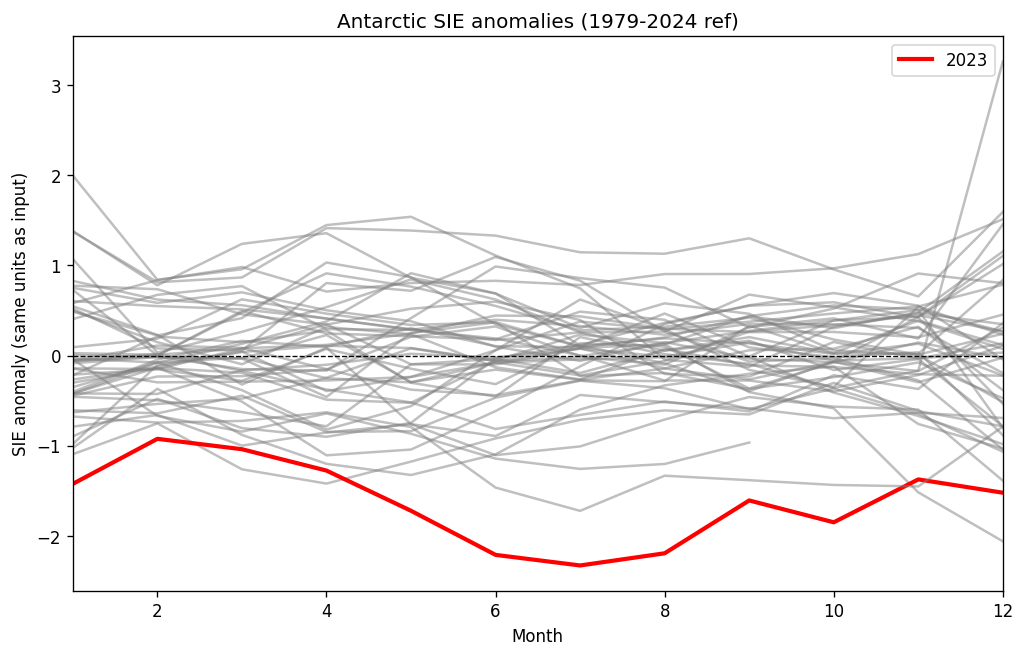

Aug 2023 anomaly (ANTSIE): -2.1926095389400952
P(ANOM <= Aug2023) using all months (1979-2024): 0.005338078291814947
P(ANOM <= Aug2023) using Augusts only: 0.02127659574468085


In [68]:
# Run the analysis (fill file paths in USER INPUT above before running)
print('Loading ANTSIE...')
ant = load_ads_monthly_csv(ANT_SIE_CSV)
print('Loaded ANTSIE rows:', len(ant))

ant_anom, ant_clim = calc_monthly_anomalies(ant, ref_start=REF_START, ref_end=REF_END)

# Plot ensemble and highlight 2023
plot_ensemble_anomalies(ant_anom, highlight_year=2023, title='Antarctic SIE anomalies (1979-2024 ref)')

# Q1.2: probability that we observe ANTSIE of Aug 2023 or smaller
aug2023_anom = get_anom_for_month(ant_anom, AUG_2023)
print('Aug 2023 anomaly (ANTSIE):', aug2023_anom)

# (a) Using all observations in Jan 1979 - Dec 2024 (all months)
all_series = ant_anom['sie_anom'].values
p_all = empirical_prob_leq(aug2023_anom, all_series)
print('P(ANOM <= Aug2023) using all months (1979-2024):', p_all)

# (b) Using only August observations across years
aug_series = ant_anom[ant_anom['month']==8]['sie_anom'].values
p_aug = empirical_prob_leq(aug2023_anom, aug_series)
print('P(ANOM <= Aug2023) using Augusts only:', p_aug)


In [69]:
# Q1.3: Reference Jan 2017 - Dec 2022
ant_anom_recent, _ = calc_monthly_anomalies(ant, ref_start=RECENT_START, ref_end=RECENT_END)
aug2023_anom_recent = get_anom_for_month(ant_anom_recent, AUG_2023)
print('Aug2023 anomaly relative to 2017-2022 ref:', aug2023_anom_recent)

p_all_recent_ref = empirical_prob_leq(aug2023_anom_recent, ant_anom_recent['sie_anom'].values)
aug_series_recent_ref = ant_anom_recent[ant_anom_recent['month']==8]['sie_anom'].values
p_aug_recent_ref = empirical_prob_leq(aug2023_anom_recent, aug_series_recent_ref)
print('P (all months, 2017-2022 ref):', p_all_recent_ref)
print('P (August only, 2017-2022 ref):', p_aug_recent_ref)


Aug2023 anomaly relative to 2017-2022 ref: -1.9134378817204318
P (all months, 2017-2022 ref): 0.0035587188612099642
P (August only, 2017-2022 ref): 0.02127659574468085


Loading ASIE...
[DEBUG] Loaded 562 rows from data/vishop_extent_arctic_sea_extent.csv
        date        sie  year  month
0 1978-12-01  13.417615  1978     12
1 1979-01-01  15.043002  1979      1
2 1979-02-01  15.833541  1979      2
3 1979-03-01  15.976665  1979      3
4 1979-04-01  15.059099  1979      4


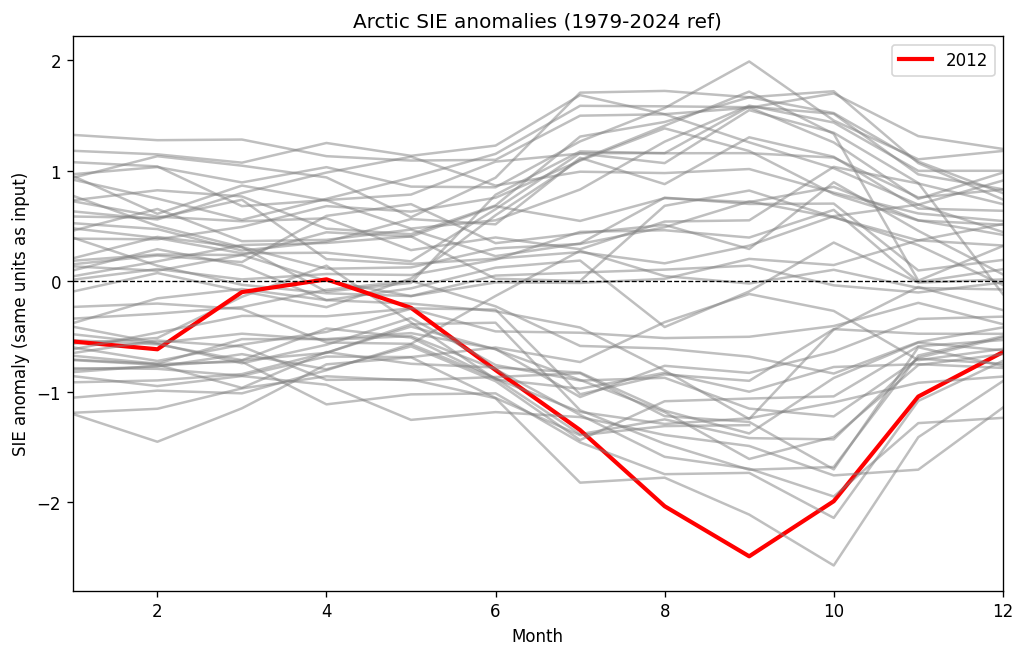

Sep 2012 anomaly (ASIE): -2.48808109224138
P(ASIE <= Sep2012) using all months: 0.0035587188612099642
P(ASIE <= Sep2012) using Septembers only: 0.02127659574468085


In [70]:
# Q1.4: Arctic ASIE and September 2012
print('Loading ASIE...')
arc = load_ads_monthly_csv(ARC_SIE_CSV)
arc_anom, arc_clim = calc_monthly_anomalies(arc, ref_start=REF_START, ref_end=REF_END)
plot_ensemble_anomalies(arc_anom, highlight_year=2012, title='Arctic SIE anomalies (1979-2024 ref)')

sep2012_anom = get_anom_for_month(arc_anom, SEP_2012)
print('Sep 2012 anomaly (ASIE):', sep2012_anom)

p_all_arc = empirical_prob_leq(sep2012_anom, arc_anom['sie_anom'].values)
sep_series = arc_anom[arc_anom['month']==9]['sie_anom'].values
p_sep = empirical_prob_leq(sep2012_anom, sep_series)
print('P(ASIE <= Sep2012) using all months:', p_all_arc)
print('P(ASIE <= Sep2012) using Septembers only:', p_sep)


In [ ]:
# Q1.5: Fit linear trend to ASIE anomalies and test significance with AR(1) correction.
# Following a practical approach that is similar to Santer et al. (2000):
#  - Fit OLS: anom = a + b * time
#  - Estimate lag-1 autocorrelation (r1) of residuals
#  - Compute effective sample size Ne = N*(1 - r1)/(1 + r1)
#  - Adjust standard error of slope by factor sqrt(N/Ne)

# Prepare data (use arc_anom, which covers 1979-2024)
adf = arc_anom.copy().dropna(subset=['sie_anom']).reset_index(drop=True)
adf = adf[(adf['year']>=REF_START) & (adf['year']<=REF_END)].copy()
adf['time_index'] = np.arange(len(adf))  # time in months
X = sm.add_constant(adf['time_index'])
y = adf['sie_anom'].values
model = sm.OLS(y, X).fit()
slope = model.params[1]
se_slope = model.bse[1]
print('OLS slope (per month):', slope, 'SE:', se_slope)

# residual lag-1 autocorrelation
resid = model.resid
# compute lag-1
r1 = np.corrcoef(resid[:-1], resid[1:])[0,1]
N = len(resid)
Ne = N * (1 - r1) / (1 + r1) if (1 + r1) != 0 else N
print('Lag-1 autocorr of residuals r1 =', r1)
print('Approx effective sample size Ne =', Ne)

# adjust standard error
se_adj = se_slope * math.sqrt(N / Ne)
t_adj = slope / se_adj
# approximate df
df_eff = max(int(np.floor(Ne - 2)), 1)
p_adj = 2 * (1 - stats.t.cdf(abs(t_adj), df=df_eff))
print('Adjusted t-statistic for slope:', t_adj, 'p-value (two-sided):', p_adj)

# If slope significant, recompute anomalies removing trend (monthly seasonal already removed)
if p_adj < 0.05:
    print('Slope is significant at 5% -> include trend when computing anomalies for ASIE.')
else:
    print('No significant slope at 5% -> trend inclusion optional.')

# If trend is significant, compute anomaly relative to trend+seasonal expected value for Sep2012
if p_adj < 0.05:
    # build trend line and subtract
    trend = model.predict(X)
    adf['sie_anom_trend_removed'] = adf['sie_anom'] - trend
    # find index for Sep2012
    val_row = adf[(adf['year']==2012) & (adf['month']==9)]
    if not val_row.empty:
        sep2012_trend_anom = float(val_row['sie_anom_trend_removed'].iloc[0])
        print('Sep2012 anomaly after removing trend (and seasonal):', sep2012_trend_anom)
        p_sep_trend = empirical_prob_leq(sep2012_trend_anom, adf['sie_anom_trend_removed'].values)
        print('Probability (Sep2012 <= value) after trend removal:', p_sep_trend)
    else:
        print('Sep2012 not found in trend dataset.')


OLS slope (per month): -0.004802734696055008 SE: 0.00010879363965585195
Lag-1 autocorr of residuals r1 = 0.7463943371839628
Approx effective sample size Ne = 80.15963112900668
Adjusted t-statistic for slope: -16.822611162466643 p-value (two-sided): 0.0
Slope is significant at 5% -> include trend when computing anomalies for ASIE.
Sep2012 anomaly after removing trend (and seasonal): -1.8709296837983096
Probability (Sep2012 <= value) after trend removal: 0.0018115942028985507


/tmp/ipykernel_97292/4262933387.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/tmp/ipykernel_97292/4262933387.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_slope = model.bse[1]
